This notebook will describe experiments related to DUD-E

In [1]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)


In [2]:
def compute_enrichment_factor(scores, labels, n_percent):
    # this variant implements the equation from Xiaohua's paper
    
    sample_n = int(np.ceil(n_percent * labels.shape[0]))
    
    sorted_scores = sorted(zip(scores, labels), key=lambda x: x[0], reverse=True)

    top_n_sorted_scores = sorted_scores[:sample_n]

    # counting number of true positives in top x% of sorted compounds
    actives_sampled = sum([y for x, y in top_n_sorted_scores])
    # labels are binary, sum to count number of actives
    actives_database = sum(labels)

    norm_factor = (sample_n/len(labels))

    return (actives_sampled / actives_database) * (labels.shape[0]/sample_n)


In [3]:
# data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/0")
data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4")

In [4]:
list(data_p.glob("dude.random*.pkl"))[0].name

'dude.random.inha.rf.None.0.pkl'

In [5]:
dude_target_names = list(set([x.name.split('.')[2] for x in list(data_p.glob("dude.random*.pkl"))]))
dude_target_names

['dyr',
 'cdk2',
 'sahh',
 'kith',
 'prgr',
 'pgh1',
 'ace',
 'mk14',
 'parp1',
 'fa10',
 'aldr',
 'pygm',
 'pnph',
 'hs90a',
 'esr1',
 'mcr',
 'src',
 'ada',
 'comt',
 'thrb',
 'pde5a',
 'egfr',
 'gcr',
 'hmdh',
 'inha',
 'nram',
 'pgh2',
 'ampc',
 'hivpr',
 'aces',
 'pur2',
 'bace1',
 'vgfr2',
 'try1',
 'hivrt',
 'rxra',
 'andr',
 'pparg']

In [48]:
def compute_average_enrichment(pkl_path, model):
    
    enrich_1_list = [] 
    enrich_10_list = []
    
#     import pdb
#     pdb.set_trace()
    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
#         for seed in data.keys():

        range_limit = 10
    
        if "openhd" in str(pkl_path):
            range_limit=1
        for seed in range(range_limit):
#             print(seed)

            if isinstance(data[seed]["y_true"], np.ndarray):
                y_true = data[seed]["y_true"]
            else:
                y_true = np.concatenate(data[seed]["y_true"]) 
            y_pred = np.array(data[seed]["y_pred"])

    
            eta = np.array(data[seed]["eta"])

            if np.unique(y_true).shape[0] < 2 :
                metric = 0
            else:
                metric = recall_score(y_pred=y_pred, y_true=y_true)
                if model in ["rf", "mlp"]:
                    eta= eta[:, 1]

            enrich_1 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.01)
            enrich_1_list.append(enrich_1)
                
            enrich_10 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.1)
            enrich_10_list.append(enrich_10)
            
    
    return np.mean(enrich_1_list), np.std(enrich_1_list), np.mean(enrich_10_list), np.std(enrich_10_list)




def compute_average_train_time(pkl_path):
    print(pkl_path)
    train_time_list = []
    

    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
        target = pkl_path.name.split(".")[2]
        split = pkl_path.name.split(".")[1]
        model = pkl_path.name.split(".")[3]

        range_limit = 10
    
        if "openhd" in model:
            range_limit=1
        for seed in range(range_limit):

            train_time  = data[seed]["train_time"]

            if "openhd" in model:
                pass
            
            elif "mlp" in model:
                train_time = train_time / 10 # trained MLP for max 10 epochs...check that it hits that but assume it didn't converge that quickly
            elif "rf" in model:
                train_time = train_time # there's no concept of epoch in a random forest
            else:
                train_time = train_time/10 # this should catch all HD models which were trained for 10 epochs per seed
            
            train_time_list.append(train_time)
            
            
    
    return np.mean(train_time_list)



def compute_average_inference_time(pkl_path):
    
    test_time_list = []
    

    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        

        range_limit = 10
    
        if "openhd" in str(pkl_path):
            range_limit=1
        for seed in range(range_limit):

            test_time  = data[seed]["test_time"]

            test_time_list.append(test_time)
            
            
    
    return np.mean(test_time_list)


def get_train_test_sizes(pkl_path):
    
    train_size_list = []
    test_size_list = []
    

    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
        range_limit = 10
    
        if "openhd" in str(pkl_path):
            range_limit=1
        for seed in range(range_limit):

            train_size_list.append(data[seed]["train_size"])
            test_size_list.append(data[seed]["test_size"])            
            
    
    return np.mean(train_size_list), np.mean(test_size_list)
                    

# DUD-E results

In [49]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

In [50]:
#     "openhd-ecfp": green_color_pal[6],

color_dict = {
    "smiles-pe.atomwise.0": rocket_color_pal[2],
    "smiles-pe.bpe.0": rocket_color_pal[4],   
"selfies.atomwise": green_color_pal[4],
    "selfies.atomwise": green_color_pal[4],
    "openhd-ecfp": green_color_pal[5],
        "openhd-rp": green_color_pal[5],
    "ecfp": green_color_pal[6],
    "rp": green_color_pal[8],
    "rf": blue_color_pal[4],
    "mlp": blue_color_pal[7],
}


model_order_list = [
    ("smiles-pe.atomwise.0", "MoleHD-Atomw."),
    ("smiles-pe.bpe.0", "MoleHD-BPE"),
    ("selfies.atomwise", "HDBind-SELFIES"),
    ("ecfp", "HDBind-ECFP"),
    ("openhd-ecfp", "OpenHD-ECFP"),
    ("openhd-rp", "OpenHD-RPFP"),
    ("rp", "HDBind-RPFP"),
    ("rf", "RF"),
    ("mlp", "MLP"),
    ("Vina", "Vina")
]


model_name_dict = {
    "smiles-pe.atomwise.0": "MoleHD-Atomw.",
    "smiles-pe.bpe.0": "MoleHD-BPE",
    "selfies.atomwise": "HDBind-SELFIES",
    "ecfp": "HDBind-ECFP",
    "openhd-ecfp": "OPENHD-ECFP",
    "openhd-rp": "OPENHD-RPFP",
    "rp": "HDBind-RPFP",
    "rf": "RF",
    "mlp": "MLP",
    "Vina": "Vina"
 }

In [53]:
def aggregate_dude_results(dataset, split):
    
    model_metric_dict = {"model": [], "enrich-1-mean": [], 
                         "enrich-1-std":[], "enrich-10-mean": [], 
                         "enrich-10-std": [], "train_time":[], "test_time": [],
                        "train_size": [], "test_size": []}
    

    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]

    for model, color in color_dict.items():
                        
        data_path_list = list(data_p.glob(f"{dataset}.{split}.*.{model}*pkl"))

        
        for path in tqdm(data_path_list, total=len(data_path_list)):
            
            target = path.name.split(".")[2]
            split = path.name.split(".")[1]
            
                
                
            enrich_1_mean, enrich_1_std, enrich_10_mean, enrich_10_std = compute_average_enrichment(path, model=model)
            train_time_mean = compute_average_train_time(path)
            test_time_mean = compute_average_inference_time(path)
            train_size, test_size = get_train_test_sizes(path)
            
            
            model_metric_dict["model"].append(model)
            model_metric_dict["enrich-1-mean"].append(enrich_1_mean)
            model_metric_dict["enrich-1-std"].append(enrich_1_std)
            model_metric_dict["enrich-10-mean"].append(enrich_10_mean)
            model_metric_dict["enrich-10-std"].append(enrich_10_std)
            model_metric_dict["train_time"].append(train_time_mean)
            model_metric_dict["test_time"].append(test_time_mean)
            model_metric_dict["train_size"].append(train_size)
            model_metric_dict["test_size"].append(test_size)


    return enrich_f, enrich_1_ax, enrich_10_ax, model_metric_dict




  5%|▌         | 2/38 [00:00<00:05,  7.16it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pnph.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.try1.smiles-pe.atomwise.0.pkl


  8%|▊         | 3/38 [00:00<00:06,  5.53it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pgh1.smiles-pe.atomwise.0.pkl


 11%|█         | 4/38 [00:00<00:07,  4.41it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.fa10.smiles-pe.atomwise.0.pkl


 13%|█▎        | 5/38 [00:01<00:09,  3.39it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pgh2.smiles-pe.atomwise.0.pkl


 16%|█▌        | 6/38 [00:01<00:13,  2.36it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.egfr.smiles-pe.atomwise.0.pkl


 21%|██        | 8/38 [00:02<00:10,  2.82it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pde5a.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.nram.smiles-pe.atomwise.0.pkl


 24%|██▎       | 9/38 [00:02<00:10,  2.84it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.esr1.smiles-pe.atomwise.0.pkl


 26%|██▋       | 10/38 [00:03<00:12,  2.33it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.parp1.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.inha.smiles-pe.atomwise.0.pkl


 34%|███▍      | 13/38 [00:03<00:06,  4.02it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ada.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.thrb.smiles-pe.atomwise.0.pkl


 37%|███▋      | 14/38 [00:04<00:07,  3.07it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hivpr.smiles-pe.atomwise.0.pkl


 42%|████▏     | 16/38 [00:05<00:07,  3.02it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.src.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.rxra.smiles-pe.atomwise.0.pkl


 47%|████▋     | 18/38 [00:05<00:04,  4.46it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hs90a.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pygm.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pur2.smiles-pe.atomwise.0.pkl


 55%|█████▌    | 21/38 [00:05<00:03,  5.01it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.bace1.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hmdh.smiles-pe.atomwise.0.pkl


 58%|█████▊    | 22/38 [00:06<00:04,  3.33it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.mk14.smiles-pe.atomwise.0.pkl


 63%|██████▎   | 24/38 [00:06<00:03,  4.30it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.gcr.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.andr.smiles-pe.atomwise.0.pkl


 66%|██████▌   | 25/38 [00:07<00:03,  3.59it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.vgfr2.smiles-pe.atomwise.0.pkl


 68%|██████▊   | 26/38 [00:07<00:04,  2.94it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.cdk2.smiles-pe.atomwise.0.pkl


 71%|███████   | 27/38 [00:07<00:03,  3.36it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.prgr.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ampc.smiles-pe.atomwise.0.pkl


 79%|███████▉  | 30/38 [00:08<00:02,  4.00it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.aces.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.aldr.smiles-pe.atomwise.0.pkl


 84%|████████▍ | 32/38 [00:08<00:01,  5.45it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.kith.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.comt.smiles-pe.atomwise.0.pkl


 92%|█████████▏| 35/38 [00:09<00:00,  6.30it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ace.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.sahh.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.mcr.smiles-pe.atomwise.0.pkl


 95%|█████████▍| 36/38 [00:09<00:00,  4.39it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pparg.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hivrt.smiles-pe.atomwise.0.pkl


100%|██████████| 38/38 [00:10<00:00,  3.77it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.dyr.smiles-pe.atomwise.0.pkl


  3%|▎         | 1/38 [00:00<00:05,  6.79it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pnph.smiles-pe.bpe.0.pkl


  5%|▌         | 2/38 [00:00<00:05,  6.54it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ada.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.inha.smiles-pe.bpe.0.pkl


 11%|█         | 4/38 [00:00<00:07,  4.59it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.aces.smiles-pe.bpe.0.pkl


 13%|█▎        | 5/38 [00:01<00:11,  2.85it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.egfr.smiles-pe.bpe.0.pkl


 16%|█▌        | 6/38 [00:02<00:13,  2.41it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.parp1.smiles-pe.bpe.0.pkl


 18%|█▊        | 7/38 [00:02<00:12,  2.57it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ace.smiles-pe.bpe.0.pkl


 21%|██        | 8/38 [00:02<00:12,  2.34it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.cdk2.smiles-pe.bpe.0.pkl


 24%|██▎       | 9/38 [00:03<00:10,  2.79it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.aldr.smiles-pe.bpe.0.pkl


 26%|██▋       | 10/38 [00:03<00:10,  2.73it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.fa10.smiles-pe.bpe.0.pkl


 32%|███▏      | 12/38 [00:03<00:06,  3.86it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.thrb.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.rxra.smiles-pe.bpe.0.pkl


 37%|███▋      | 14/38 [00:04<00:04,  4.96it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.try1.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pygm.smiles-pe.bpe.0.pkl


 39%|███▉      | 15/38 [00:04<00:05,  4.33it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.dyr.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.sahh.smiles-pe.bpe.0.pkl


 45%|████▍     | 17/38 [00:04<00:05,  3.91it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pparg.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.kith.smiles-pe.bpe.0.pkl


 53%|█████▎    | 20/38 [00:05<00:03,  4.99it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.prgr.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.nram.smiles-pe.bpe.0.pkl


 55%|█████▌    | 21/38 [00:06<00:05,  3.38it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.mk14.smiles-pe.bpe.0.pkl


 58%|█████▊    | 22/38 [00:06<00:04,  3.31it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.bace1.smiles-pe.bpe.0.pkl


 63%|██████▎   | 24/38 [00:07<00:04,  3.21it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hivpr.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ampc.smiles-pe.bpe.0.pkl


 71%|███████   | 27/38 [00:07<00:02,  5.21it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hmdh.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pur2.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.comt.smiles-pe.bpe.0.pkl


 74%|███████▎  | 28/38 [00:07<00:02,  4.22it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.vgfr2.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hivrt.smiles-pe.bpe.0.pkl


 79%|███████▉  | 30/38 [00:08<00:01,  5.36it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.andr.smiles-pe.bpe.0.pkl


 82%|████████▏ | 31/38 [00:08<00:01,  4.59it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.esr1.smiles-pe.bpe.0.pkl


 84%|████████▍ | 32/38 [00:08<00:01,  4.62it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pgh1.smiles-pe.bpe.0.pkl


 87%|████████▋ | 33/38 [00:09<00:01,  3.52it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pde5a.smiles-pe.bpe.0.pkl


 89%|████████▉ | 34/38 [00:09<00:01,  2.55it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.src.smiles-pe.bpe.0.pkl


 92%|█████████▏| 35/38 [00:10<00:01,  2.57it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pgh2.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.mcr.smiles-pe.bpe.0.pkl


100%|██████████| 38/38 [00:10<00:00,  3.62it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.gcr.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hs90a.smiles-pe.bpe.0.pkl


  5%|▌         | 2/38 [00:00<00:07,  5.03it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pgh2.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hs90a.selfies.atomwise.0.pkl


  8%|▊         | 3/38 [00:00<00:11,  2.92it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.cdk2.selfies.atomwise.0.pkl


 11%|█         | 4/38 [00:01<00:09,  3.45it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.thrb.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.mcr.selfies.atomwise.0.pkl


 16%|█▌        | 6/38 [00:01<00:10,  3.01it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.egfr.selfies.atomwise.0.pkl


 21%|██        | 8/38 [00:02<00:07,  4.01it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pgh1.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.nram.selfies.atomwise.0.pkl


 24%|██▎       | 9/38 [00:02<00:06,  4.41it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.gcr.selfies.atomwise.0.pkl


 29%|██▉       | 11/38 [00:02<00:05,  4.66it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.esr1.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.sahh.selfies.atomwise.0.pkl


 34%|███▍      | 13/38 [00:03<00:04,  5.79it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.inha.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.aldr.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pur2.selfies.atomwise.0.pkl


 42%|████▏     | 16/38 [00:03<00:03,  5.70it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ace.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.andr.selfies.atomwise.0.pkl


 45%|████▍     | 17/38 [00:03<00:03,  5.77it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pnph.selfies.atomwise.0.pkl


 47%|████▋     | 18/38 [00:04<00:03,  5.44it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.prgr.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pygm.selfies.atomwise.0.pkl


 53%|█████▎    | 20/38 [00:04<00:03,  4.99it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.vgfr2.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ampc.selfies.atomwise.0.pkl


 58%|█████▊    | 22/38 [00:04<00:02,  5.87it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hmdh.selfies.atomwise.0.pkl


 63%|██████▎   | 24/38 [00:05<00:03,  4.43it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.parp1.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.rxra.selfies.atomwise.0.pkl


 66%|██████▌   | 25/38 [00:05<00:03,  3.58it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pparg.selfies.atomwise.0.pkl


 68%|██████▊   | 26/38 [00:06<00:03,  3.10it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.aces.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hivrt.selfies.atomwise.0.pkl


 76%|███████▋  | 29/38 [00:06<00:02,  4.31it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.fa10.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.comt.selfies.atomwise.0.pkl


 82%|████████▏ | 31/38 [00:07<00:01,  3.64it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.src.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ada.selfies.atomwise.0.pkl


 84%|████████▍ | 32/38 [00:07<00:01,  3.59it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.bace1.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.try1.selfies.atomwise.0.pkl


 89%|████████▉ | 34/38 [00:08<00:01,  3.18it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pde5a.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.kith.selfies.atomwise.0.pkl


 95%|█████████▍| 36/38 [00:08<00:00,  3.90it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.dyr.selfies.atomwise.0.pkl


 97%|█████████▋| 37/38 [00:09<00:00,  2.89it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.mk14.selfies.atomwise.0.pkl


100%|██████████| 38/38 [00:10<00:00,  3.78it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hivpr.selfies.atomwise.0.pkl


 21%|██        | 8/38 [00:00<00:00, 75.81it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.rxra.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.bace1.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hmdh.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.inha.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.comt.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pnph.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.dyr.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.thrb.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ada.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/resul

 61%|██████    | 23/38 [00:00<00:00, 66.61it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.src.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pgh2.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.mk14.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.nram.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.gcr.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.fa10.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pur2.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.vgfr2.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.egfr.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/resul

 97%|█████████▋| 37/38 [00:00<00:00, 65.19it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.prgr.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.try1.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.esr1.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.andr.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.mcr.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pparg.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.cdk2.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hs90a.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.sahh.openhd-ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/res

100%|██████████| 38/38 [00:00<00:00, 65.24it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hivpr.openhd-ecfp.atomwise.0.pkl


  0%|          | 0/38 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ampc.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.aces.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.aldr.openhd-rp.atomwise.0.pkl


 21%|██        | 8/38 [00:00<00:00, 78.33it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.kith.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.comt.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ace.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.sahh.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.mcr.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pparg.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hivrt.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.dyr.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.mk14.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.h

 42%|████▏     | 16/38 [00:00<00:00, 63.50it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.gcr.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.andr.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.vgfr2.openhd-rp.atomwise.0.pkl


 61%|██████    | 23/38 [00:00<00:00, 62.02it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.cdk2.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.prgr.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.thrb.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ada.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hivpr.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.src.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.rxra.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hs90a.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pygm.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.

 82%|████████▏ | 31/38 [00:00<00:00, 66.43it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.fa10.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pgh2.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.egfr.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.nram.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pde5a.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.esr1.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.parp1.openhd-rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.inha.openhd-rp.atomwise.0.pkl


  3%|▎         | 1/38 [00:00<00:04,  8.02it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.comt.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pur2.ecfp.atomwise.0.pkl


 11%|█         | 4/38 [00:00<00:05,  6.66it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pgh1.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.andr.ecfp.atomwise.0.pkl


 13%|█▎        | 5/38 [00:00<00:07,  4.60it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.esr1.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hivrt.ecfp.atomwise.0.pkl


 18%|█▊        | 7/38 [00:01<00:06,  4.67it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.vgfr2.ecfp.atomwise.0.pkl


 21%|██        | 8/38 [00:01<00:07,  3.98it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.bace1.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hmdh.ecfp.atomwise.0.pkl


 26%|██▋       | 10/38 [00:02<00:09,  2.98it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hivpr.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ampc.ecfp.atomwise.0.pkl


 32%|███▏      | 12/38 [00:02<00:07,  3.52it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pgh2.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.mcr.ecfp.atomwise.0.pkl


 37%|███▋      | 14/38 [00:03<00:05,  4.58it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hs90a.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.gcr.ecfp.atomwise.0.pkl


 42%|████▏     | 16/38 [00:03<00:05,  3.67it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pde5a.ecfp.atomwise.0.pkl


 45%|████▍     | 17/38 [00:04<00:07,  2.80it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.src.ecfp.atomwise.0.pkl


 47%|████▋     | 18/38 [00:04<00:06,  2.87it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ace.ecfp.atomwise.0.pkl


 50%|█████     | 19/38 [00:05<00:07,  2.53it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.cdk2.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.thrb.ecfp.atomwise.0.pkl


 55%|█████▌    | 21/38 [00:05<00:05,  2.99it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.fa10.ecfp.atomwise.0.pkl


 61%|██████    | 23/38 [00:06<00:03,  3.77it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.aldr.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ada.ecfp.atomwise.0.pkl


 66%|██████▌   | 25/38 [00:06<00:02,  5.06it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.inha.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pnph.ecfp.atomwise.0.pkl


 68%|██████▊   | 26/38 [00:06<00:03,  3.50it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.parp1.ecfp.atomwise.0.pkl


 71%|███████   | 27/38 [00:07<00:03,  3.03it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.aces.ecfp.atomwise.0.pkl


 74%|███████▎  | 28/38 [00:08<00:04,  2.42it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.egfr.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.sahh.ecfp.atomwise.0.pkl


 79%|███████▉  | 30/38 [00:08<00:03,  2.60it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.mk14.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.nram.ecfp.atomwise.0.pkl


 84%|████████▍ | 32/38 [00:09<00:01,  3.30it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.prgr.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.kith.ecfp.atomwise.0.pkl


 89%|████████▉ | 34/38 [00:09<00:01,  3.47it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pparg.ecfp.atomwise.0.pkl


 92%|█████████▏| 35/38 [00:09<00:00,  3.41it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.dyr.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pygm.ecfp.atomwise.0.pkl


100%|██████████| 38/38 [00:10<00:00,  3.65it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.try1.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.rxra.ecfp.atomwise.0.pkl


  3%|▎         | 1/38 [00:00<00:03,  9.34it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pygm.rp.atomwise.0.pkl


  5%|▌         | 2/38 [00:00<00:08,  4.15it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ace.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.kith.rp.atomwise.0.pkl


 11%|█         | 4/38 [00:01<00:09,  3.76it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pde5a.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pur2.rp.atomwise.0.pkl


 16%|█▌        | 6/38 [00:01<00:09,  3.32it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hivpr.rp.atomwise.0.pkl


 18%|█▊        | 7/38 [00:02<00:10,  2.90it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hmdh.rp.atomwise.0.pkl


 21%|██        | 8/38 [00:03<00:16,  1.84it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.mk14.rp.atomwise.0.pkl


 24%|██▎       | 9/38 [00:03<00:15,  1.82it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.src.rp.atomwise.0.pkl


 26%|██▋       | 10/38 [00:04<00:12,  2.23it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.try1.rp.atomwise.0.pkl


 29%|██▉       | 11/38 [00:04<00:12,  2.15it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.cdk2.rp.atomwise.0.pkl


 32%|███▏      | 12/38 [00:04<00:11,  2.29it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pgh2.rp.atomwise.0.pkl


 34%|███▍      | 13/38 [00:05<00:10,  2.49it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.bace1.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hivrt.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hs90a.rp.atomwise.0.pkl


 42%|████▏     | 16/38 [00:06<00:07,  2.81it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.egfr.rp.atomwise.0.pkl


 45%|████▍     | 17/38 [00:06<00:06,  3.20it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.aldr.rp.atomwise.0.pkl


 47%|████▋     | 18/38 [00:06<00:05,  3.45it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.prgr.rp.atomwise.0.pkl


 53%|█████▎    | 20/38 [00:07<00:04,  3.68it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.aces.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ada.rp.atomwise.0.pkl


 55%|█████▌    | 21/38 [00:07<00:04,  3.86it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pgh1.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ampc.rp.atomwise.0.pkl


 63%|██████▎   | 24/38 [00:07<00:02,  5.32it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.andr.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.rxra.rp.atomwise.0.pkl


 68%|██████▊   | 26/38 [00:07<00:01,  6.99it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.mcr.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.inha.rp.atomwise.0.pkl


 71%|███████   | 27/38 [00:07<00:01,  6.50it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.thrb.rp.atomwise.0.pkl


 74%|███████▎  | 28/38 [00:08<00:02,  4.95it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.fa10.rp.atomwise.0.pkl


 76%|███████▋  | 29/38 [00:08<00:02,  4.25it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.esr1.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pnph.rp.atomwise.0.pkl


 82%|████████▏ | 31/38 [00:09<00:01,  3.52it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pparg.rp.atomwise.0.pkl


 84%|████████▍ | 32/38 [00:09<00:01,  3.46it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.dyr.rp.atomwise.0.pkl


 87%|████████▋ | 33/38 [00:10<00:01,  2.78it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.parp1.rp.atomwise.0.pkl


 89%|████████▉ | 34/38 [00:10<00:01,  3.19it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.gcr.rp.atomwise.0.pkl


 92%|█████████▏| 35/38 [00:10<00:01,  2.91it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.vgfr2.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.sahh.rp.atomwise.0.pkl


100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.comt.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.nram.rp.atomwise.0.pkl


  0%|          | 0/38 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.inha.rf.None.0.pkl


  5%|▌         | 2/38 [00:00<00:04,  8.77it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.vgfr2.rf.None.0.pkl


  8%|▊         | 3/38 [00:00<00:03,  8.82it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.try1.rf.None.0.pkl


 11%|█         | 4/38 [00:00<00:04,  8.19it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.gcr.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.kith.rf.None.0.pkl


 16%|█▌        | 6/38 [00:00<00:03, 10.32it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pnph.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ace.rf.None.0.pkl


 21%|██        | 8/38 [00:01<00:04,  6.76it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.egfr.rf.None.0.pkl


 24%|██▎       | 9/38 [00:01<00:04,  5.89it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hivpr.rf.None.0.pkl


 26%|██▋       | 10/38 [00:01<00:05,  5.31it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.src.rf.None.0.pkl


 29%|██▉       | 11/38 [00:01<00:05,  4.93it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.parp1.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.comt.rf.None.0.pkl


 39%|███▉      | 15/38 [00:02<00:02,  7.80it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.fa10.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ampc.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pur2.rf.None.0.pkl


 42%|████▏     | 16/38 [00:02<00:02,  7.97it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pgh1.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.rxra.rf.None.0.pkl


 47%|████▋     | 18/38 [00:02<00:02,  6.96it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.mk14.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hivrt.rf.None.0.pkl


 53%|█████▎    | 20/38 [00:02<00:02,  7.72it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.esr1.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.aces.rf.None.0.pkl


 58%|█████▊    | 22/38 [00:03<00:02,  6.63it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pparg.rf.None.0.pkl


 63%|██████▎   | 24/38 [00:03<00:02,  6.64it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pde5a.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.prgr.rf.None.0.pkl


 68%|██████▊   | 26/38 [00:03<00:01,  8.13it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pygm.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hs90a.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.mcr.rf.None.0.pkl


 76%|███████▋  | 29/38 [00:03<00:00,  9.18it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hmdh.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.aldr.rf.None.0.pkl


 82%|████████▏ | 31/38 [00:04<00:00,  7.93it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.cdk2.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.nram.rf.None.0.pkl


 87%|████████▋ | 33/38 [00:04<00:00,  7.68it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.dyr.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ada.rf.None.0.pkl


 92%|█████████▏| 35/38 [00:04<00:00,  7.85it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.sahh.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.bace1.rf.None.0.pkl


 97%|█████████▋| 37/38 [00:05<00:00,  8.13it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.andr.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.thrb.rf.None.0.pkl


100%|██████████| 38/38 [00:05<00:00,  7.27it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pgh2.rf.None.0.pkl


  0%|          | 0/38 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.try1.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ada.mlp.None.0.pkl


 11%|█         | 4/38 [00:00<00:04,  7.35it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.parp1.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.nram.mlp.None.0.pkl


 18%|█▊        | 7/38 [00:00<00:04,  7.68it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.src.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.kith.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hivrt.mlp.None.0.pkl


 21%|██        | 8/38 [00:01<00:03,  7.84it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.gcr.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pde5a.mlp.None.0.pkl


 32%|███▏      | 12/38 [00:01<00:03,  7.82it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.mk14.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.sahh.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.comt.mlp.None.0.pkl


 37%|███▋      | 14/38 [00:01<00:03,  6.91it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.fa10.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ace.mlp.None.0.pkl


 39%|███▉      | 15/38 [00:02<00:03,  7.08it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pgh1.mlp.None.0.pkl


 42%|████▏     | 16/38 [00:02<00:03,  5.76it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.cdk2.mlp.None.0.pkl


 45%|████▍     | 17/38 [00:02<00:04,  5.05it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hivpr.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hs90a.mlp.None.0.pkl


 50%|█████     | 19/38 [00:02<00:03,  5.24it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.egfr.mlp.None.0.pkl


 58%|█████▊    | 22/38 [00:03<00:02,  6.68it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pparg.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pygm.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.rxra.mlp.None.0.pkl


 61%|██████    | 23/38 [00:03<00:02,  6.55it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.vgfr2.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.mcr.mlp.None.0.pkl


 66%|██████▌   | 25/38 [00:03<00:01,  7.40it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.dyr.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pgh2.mlp.None.0.pkl


 74%|███████▎  | 28/38 [00:04<00:01,  7.64it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.hmdh.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.andr.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.inha.mlp.None.0.pkl


 82%|████████▏ | 31/38 [00:04<00:00,  8.72it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.thrb.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pnph.mlp.None.0.pkl


 87%|████████▋ | 33/38 [00:04<00:00,  8.10it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.bace1.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.aldr.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.pur2.mlp.None.0.pkl


 92%|█████████▏| 35/38 [00:04<00:00,  8.26it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.esr1.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.ampc.mlp.None.0.pkl


 97%|█████████▋| 37/38 [00:05<00:00,  7.97it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.aces.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/dude.random.prgr.mlp.None.0.pkl


100%|██████████| 38/38 [00:05<00:00,  7.04it/s]


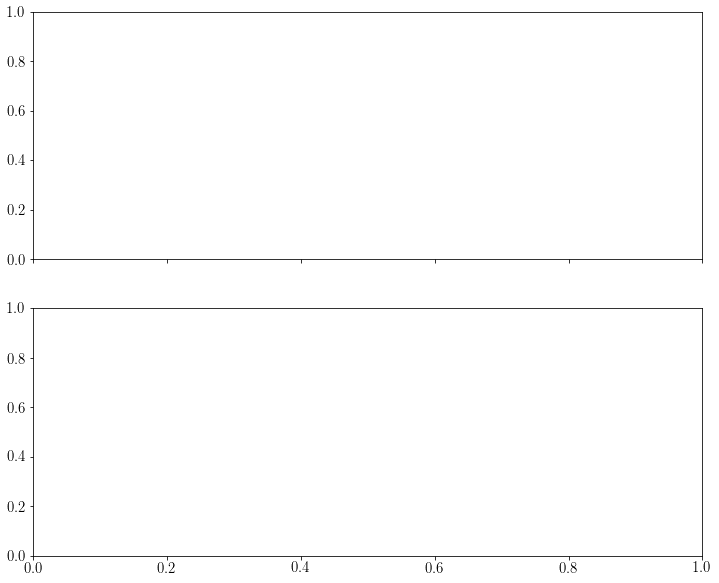

In [54]:
dude_enrich_f, dude_enrich_1_ax, dude_enrich_10_ax, model_metric_dict = aggregate_dude_results(dataset="dude", split="random")


In [55]:
model_metric_dict.keys()

dict_keys(['model', 'enrich-1-mean', 'enrich-1-std', 'enrich-10-mean', 'enrich-10-std', 'train_time', 'test_time', 'train_size', 'test_size'])

In [56]:
[(x[0], len(x[1])) for x in model_metric_dict.items()]

[('model', 342),
 ('enrich-1-mean', 342),
 ('enrich-1-std', 342),
 ('enrich-10-mean', 342),
 ('enrich-10-std', 342),
 ('train_time', 342),
 ('test_time', 342),
 ('train_size', 342),
 ('test_size', 342)]

In [57]:
model_metric_df = pd.DataFrame(model_metric_dict)

# for col in model_metric_df.columns:
#     model_model_metric_df[col].apply(lambda x: x[0])
#     model_metric_df[col].apply(lambda x: x[1])
#     model_metric_df[col].apply(lambda x: x[2])
    
# model_metric_df_list = [pd.DataFrame({"metric": [tup[0] for tup in model_metric_df[col].values],
#                                       "enrich-1": [tup[1] for tup in model_metric_df[col].values],
#                                       "enrich-10": [tup[2] for tup in model_metric_df[col].values]
#                                       "model": [col]*len(model_metric_df)} for col in model_metric_df.columns)]


# model_metric_df = pd.concat(model_metric_df_list)

# model_metric_df["latency"] = model_metric_df["test_time"] / model_metric_df["test_size"]

model_metric_df


,model,enrich-1-mean,enrich-1-std,enrich-10-mean,enrich-10-std,train_time,test_time,train_size,test_size
0,smiles-pe.atomwise.0,91.857143,0.000000e+00,9.892308,0.000000e+00,0.874518,0.135526,5145.0,643.0
1,smiles-pe.atomwise.0,16.688889,0.000000e+00,8.256608,2.812132e-01,1.046939,0.218363,6022.0,751.0
2,smiles-pe.atomwise.0,43.984286,1.332857e+00,9.358359,1.890578e-01,1.222343,0.195387,7420.0,933.0
3,smiles-pe.atomwise.0,32.840000,7.105427e-15,9.414133,9.120714e-02,3.076663,0.435076,13168.0,1642.0
4,smiles-pe.atomwise.0,47.416667,7.105427e-15,9.705166,0.000000e+00,2.245790,0.331386,13688.0,1707.0
...,...,...,...,...,...,...,...,...,...
337,mlp,58.000000,0.000000e+00,9.666667,1.776357e-15,0.255127,0.007313,1855.0,232.0
338,mlp,40.512821,0.000000e+00,9.743590,1.776357e-15,0.468919,0.013278,12693.0,1580.0
339,mlp,22.125000,7.375000e+00,6.391667,9.198241e-01,0.191531,0.009194,2322.0,295.0
340,mlp,58.527778,7.105427e-15,9.958044,8.321485e-02,0.455344,0.020553,16925.0,2107.0


In [58]:
# model_metric_df['enrich-1'] = model_metric_df['enrich-1'].apply(lambda x: float(np.array(x)))
# model_metric_df['enrich-10'] = model_metric_df['enrich-10'].apply(lambda x: float(np.array(x)))

## Vina Docking baseline

In [59]:
vina_root_p = Path("/p/lustre1/jones289/DUDE-38/")


color_dict.update({"Vina": "salmon"})



vina_path_list = [path for path in vina_root_p.glob("*-active-summary.txt")]


df_list = []


# root_dude_dir = Path("/g/g13/jones289/workspace/hd-cuda-master/datasets/dude/dude_smiles/")
root_dude_dir = Path("/usr/workspace/atom/gbsa_modeling/dude_smiles/")
for idx, path in  enumerate(vina_path_list):
#     print(idx, path)
    target = path.name.split(".")[0].split("-")[0]
    print(target, idx+1, path)
    
    # for some reason don't have inactive data for abl1
    if target in ["abl1"]:
        continue
    if target in dude_target_names:
    
        active_df = pd.read_csv(f"/p/lustre1/jones289/DUDE-38/{target}-active-summary.txt", header=None, delim_whitespace=True)
        active_df['y_true'] = [1] * len(active_df)
    
        decoy_df = pd.read_csv(f"/p/lustre1/jones289/DUDE-38/{target}-decoy-summary.txt", header=None, delim_whitespace=True)
        decoy_df['y_true'] = [0] * len(decoy_df)
    
    
        target_df = pd.concat([active_df, decoy_df])
        
        target_df["target"] = [target] * len(target_df)
    
        target_df["vina"] = target_df[2]
        target_df["gbsa"] = target_df[3]
        
        target_df["cmpd_id"] = target_df[1]
        
        target_df["target_size"] = target_df.shape[0]
        
#         import pdb
#         pdb.set_trace()
        random_split_df = pd.read_csv(root_dude_dir/ Path(f"{target}_gbsa_smiles_with_base_rdkit_smiles_train_valid_test_random_random.csv"))
        
        
#         import pdb
#         pdb.set_trace()

        # we only use the scores from the test set to attempt an even comparison
    
        merged_df = pd.merge(target_df, random_split_df, on="cmpd_id")
        merged_df = merged_df.loc[merged_df['subset'] == "test"]

        print(merged_df.shape)
    
        df_list.append(merged_df)
    else:
        pass

df = pd.concat(df_list)
    

pgh1 1 /p/lustre1/jones289/DUDE-38/pgh1-active-summary.txt
(941, 11)
rxra 2 /p/lustre1/jones289/DUDE-38/rxra-active-summary.txt
(568, 11)
pnph 3 /p/lustre1/jones289/DUDE-38/pnph-active-summary.txt
(655, 11)
ampc 4 /p/lustre1/jones289/DUDE-38/ampc-active-summary.txt
(295, 11)
try1 5 /p/lustre1/jones289/DUDE-38/try1-active-summary.txt
(782, 11)
parp1 6 /p/lustre1/jones289/DUDE-38/parp1-active-summary.txt
(2673, 11)
comt 7 /p/lustre1/jones289/DUDE-38/comt-active-summary.txt
(406, 11)
andr 8 /p/lustre1/jones289/DUDE-38/andr-active-summary.txt
(643, 11)
sahh 9 /p/lustre1/jones289/DUDE-38/sahh-active-summary.txt
(336, 11)
ace 10 /p/lustre1/jones289/DUDE-38/ace-active-summary.txt
(1587, 11)
cdk2 11 /p/lustre1/jones289/DUDE-38/cdk2-active-summary.txt
(2604, 11)
fgfr1 12 /p/lustre1/jones289/DUDE-38/fgfr1-active-summary.txt
hmdh 13 /p/lustre1/jones289/DUDE-38/hmdh-active-summary.txt
(789, 11)
nram 14 /p/lustre1/jones289/DUDE-38/nram-active-summary.txt
(587, 11)
aces 15 /p/lustre1/jones289/DUDE-3

In [60]:
set(df['target'].values.tolist())

{'ace',
 'aces',
 'ada',
 'aldr',
 'ampc',
 'andr',
 'bace1',
 'cdk2',
 'comt',
 'dyr',
 'egfr',
 'esr1',
 'fa10',
 'gcr',
 'hivpr',
 'hivrt',
 'hmdh',
 'hs90a',
 'inha',
 'kith',
 'mcr',
 'mk14',
 'nram',
 'parp1',
 'pde5a',
 'pgh1',
 'pgh2',
 'pnph',
 'pparg',
 'prgr',
 'pur2',
 'pygm',
 'rxra',
 'sahh',
 'src',
 'thrb',
 'try1',
 'vgfr2'}

In [61]:
df

,0,1,2,3,y_true,target,vina,gbsa,cmpd_id,target_size,subset
65,158,CHEMBL178355,-7.3,-23.4889,1,pgh1,-7.3,-23.4889,CHEMBL178355,9475,test
68,161,CHEMBL283267,-7.7,-26.2514,1,pgh1,-7.7,-26.2514,CHEMBL283267,9475,test
69,162,CHEMBL184374,-7.1,-22.7434,1,pgh1,-7.1,-22.7434,CHEMBL184374,9475,test
79,171,CHEMBL433892,-7.3,-29.1098,1,pgh1,-7.3,-29.1098,CHEMBL433892,9475,test
90,180,CHEMBL404928,-6.6,-22.1502,1,pgh1,-6.6,-22.1502,CHEMBL404928,9475,test
...,...,...,...,...,...,...,...,...,...,...,...
8660,994,ZINC35141443,-7.8,-28.5967,0,gcr,-7.8,-28.5967,ZINC35141443,11247,test
8661,9941,ZINC08387402,-7.3,-5.9566,0,gcr,-7.3,-5.9566,ZINC08387402,11247,test
8678,9969,ZINC64795840,-7.4,-20.0953,0,gcr,-7.4,-20.0953,ZINC64795840,11247,test
8698,9992,ZINC02647100,-5.5,-11.0534,0,gcr,-5.5,-11.0534,ZINC02647100,11247,test


In [62]:
target_size_list = []
vina_enrich_1_list = []
vina_enrich_10_list = []

for target, target_df in df.groupby("target"):
    
    ef_1 = compute_enrichment_factor(scores=np.abs(target_df["vina"]), labels=target_df["y_true"], n_percent=0.01)
    ef_10 = compute_enrichment_factor(scores=np.abs(target_df["vina"]), labels=target_df["y_true"], n_percent=0.1)

    
    target_size_list.append(target_df.shape[0])
    
    vina_enrich_1_list.append(ef_1)
    vina_enrich_10_list.append(ef_10)
    
    
    print(f"{target}, {ef_1:.4f}\t{ef_10:.4f}\t{target_df.shape[0]}")
    
sorted_vina_enrich_1_list = [x for _, x in sorted(zip(target_size_list, vina_enrich_1_list), key=lambda pair: pair[0])]
sorted_vina_enrich_10_list = [x for _, x in sorted(zip(target_size_list, vina_enrich_10_list), key=lambda pair: pair[0])]



ace, 1.6811	1.3534	1587
aces, 12.2992	4.7184	2126
ada, 0.0000	0.2302	574
aldr, 3.5769	1.5330	837
ampc, 0.0000	1.2292	295
andr, 18.3714	2.9677	643
bace1, 3.6061	2.6398	1529
cdk2, 1.4183	1.7606	2604
comt, 0.0000	0.9002	406
dyr, 0.0000	1.7635	1459
egfr, 4.3677	2.2381	3219
esr1, 3.6968	2.2181	1597
fa10, 5.4376	2.1879	1687
gcr, 0.0000	2.3696	872
hivpr, 1.3017	3.1342	3087
hivrt, 0.0000	2.6167	157
hmdh, 0.0000	0.9665	789
hs90a, 0.0000	0.0000	466
inha, 0.0000	1.7438	211
kith, 0.0000	0.5402	282
mcr, 9.7333	3.8933	146
mk14, 7.4759	2.5798	3079
nram, 0.0000	0.0000	587
parp1, 10.4211	3.9371	2673
pde5a, 8.6297	2.4922	2223
pgh1, 0.0000	1.1006	941
pgh2, 4.0780	3.1823	1725
pnph, 5.1984	2.2054	655
pparg, 5.8793	4.6167	2265
prgr, 12.3974	4.0899	967
pur2, 6.1795	5.1908	241
pygm, 0.0000	0.9015	357
rxra, 18.9333	9.9649	568
sahh, 0.0000	0.0000	336
src, 3.2879	1.9727	2992
thrb, 4.9508	4.0506	880
try1, 2.7153	1.7873	782
vgfr2, 21.6409	4.8374	1864


I think it would be good to move away from the per-target (sorted by size) scatter plot and instead make a series of box plots...this should make it easier to compare the enrichment factors as you increase the amount of data that you are allowed to screen

In [63]:
model_metric_df = pd.concat([model_metric_df, pd.DataFrame({"metric": [0]*38, "enrich-1-mean": sorted_vina_enrich_1_list, 
                                            "enrich-10-mean": sorted_vina_enrich_10_list,
                                          "model": ["Vina"]*38, 
                                                           })])


model_metric_df

,model,enrich-1-mean,enrich-1-std,enrich-10-mean,enrich-10-std,train_time,test_time,train_size,test_size,metric
0,smiles-pe.atomwise.0,91.857143,0.000000e+00,9.892308,0.000000,0.874518,0.135526,5145.0,643.0,NaN
1,smiles-pe.atomwise.0,16.688889,0.000000e+00,8.256608,0.281213,1.046939,0.218363,6022.0,751.0,NaN
2,smiles-pe.atomwise.0,43.984286,1.332857e+00,9.358359,0.189058,1.222343,0.195387,7420.0,933.0,NaN
3,smiles-pe.atomwise.0,32.840000,7.105427e-15,9.414133,0.091207,3.076663,0.435076,13168.0,1642.0,NaN
4,smiles-pe.atomwise.0,47.416667,7.105427e-15,9.705166,0.000000,2.245790,0.331386,13688.0,1707.0,NaN
...,...,...,...,...,...,...,...,...,...,...
33,Vina,10.421053,NaN,3.937058,NaN,NaN,NaN,NaN,NaN,0.0
34,Vina,3.287912,NaN,1.972747,NaN,NaN,NaN,NaN,NaN,0.0
35,Vina,7.475893,NaN,2.579807,NaN,NaN,NaN,NaN,NaN,0.0
36,Vina,1.301708,NaN,3.134209,NaN,NaN,NaN,NaN,NaN,0.0


In [64]:
sns.boxplot(data=model_metric_df[model_metric_df["model"].apply(lambda x: "openhd" not in x.lower())], x="model", y="enrich-1-mean", ax=dude_enrich_1_ax, palette=color_dict)
# dude_enrich_1_ax.set_title("(a) DUD-E Enrichment at 1\%", fontdict={"fontsize": 18})
dude_enrich_1_ax.tick_params(axis="x", labelrotation=22.5)
dude_enrich_1_ax.set_xlabel("")
dude_enrich_1_ax.set_ylabel("EF")

# labels = [x[1] for x in model_order_list]

# dude_enrich_1_ax.set_xticklabels(labels)


Text(3.2000000000000135, 0.5, 'EF')

In [65]:
sns.boxplot(data=model_metric_df[model_metric_df["model"].apply(lambda x: "openhd" not in x.lower())], x="model", y="enrich-10-mean", ax=dude_enrich_10_ax, palette=color_dict)
# dude_enrich_10_ax.set_title("(b) DUD-E Enrichment at 10\%", fontdict={"fontsize": 18})

dude_enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
# dude_enrich_10_ax.tick_params(axis="y")
dude_enrich_10_ax.set_xlabel("")
dude_enrich_10_ax.set_ylabel("EF")

labels = [model_name_dict[x.get_text()] for x in dude_enrich_10_ax.get_xticklabels()]
dude_enrich_10_ax.set_xticklabels(labels)


# # dude_enrich_10_ax.set_xticklabels(labels)
# plt.tight_layout()
dude_enrich_f.savefig("dude_enrich.png", dpi=600, bbox_inches="tight")


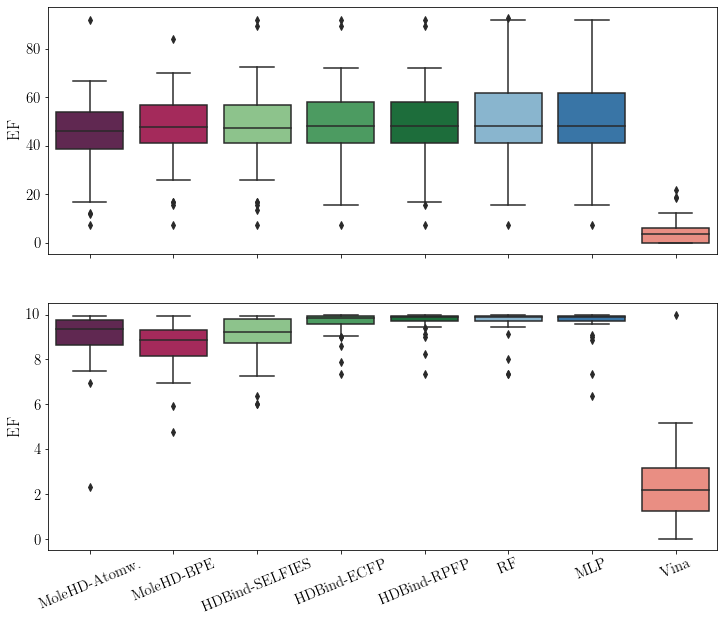

In [66]:
dude_enrich_f

In [67]:
model_metric_df[model_metric_df['model'] == "rp"].shape
for group_name, group_df in model_metric_df.groupby("model"):
    print(group_df.shape)

(38, 10)
(38, 10)
(38, 10)
(38, 10)
(38, 10)
(38, 10)
(38, 10)
(38, 10)
(38, 10)
(38, 10)


In [68]:
model_metric_df.groupby('model').describe()[['enrich-1-mean', 'enrich-10-mean']]

enrich-1-mean                                         \
                             count       mean        std   min        25%   
model                                                                       
Vina                          38.0   4.665199   5.764932  0.00   0.000000   
ecfp                          38.0  48.879478  18.618741  7.35  41.018336   
mlp                           38.0  49.651707  19.416390  7.35  41.018336   
openhd-ecfp                   38.0   5.681031  12.342704  0.00   0.000000   
openhd-rp                     38.0  21.930473  26.149160  0.00   0.000000   
rf                            38.0  50.299595  20.273109  7.35  41.018336   
rp                            38.0  48.841328  18.606270  7.35  41.018336   
selfies.atomwise              38.0  46.885436  18.268510  7.35  41.018336   
smiles-pe.atomwise.0          38.0  44.385852  16.940196  7.35  38.510900   
smiles-pe.bpe.0               38.0  47.343310  16.186690  7.35  40.973157   

                                                      enrich-10-mean  \
                            50%        75%        max          count   
model                                                                  
Vina                   3.432418   6.104440  21.640867           38.0   
ecfp                  47.991764  57.995687  91.857143           38.0   
mlp                   47.991764  61.548611  91.857143           38.0   
openhd-ecfp            0.000000   4.166640  51.333333           38.0   
openhd-rp              5.602974  39.773880  89.166667           38.0   
rf                    47.991764  61.548611  92.600000           38.0   
rp                    47.991764  57.850000  91.857143           38.0   
selfies.atomwise      47.351190  56.754167  91.857143           38.0   
smiles-pe.atomwise.0  45.882057  53.679319  91.857143           38.0   
smiles-pe.bpe.0       47.499828  56.800000  83.983673           38.0   

                                                                        \
                          mean       std       min       25%       50%   
model                                                                    
Vina                  2.471403  1.886596  0.000000  1.260218  2.211721   
ecfp                  9.610850  0.584149  7.350000  9.581469  9.839481   
mlp                   9.641049  0.722382  6.391667  9.735985  9.897767   
openhd-ecfp           2.135541  2.336629  0.000000  0.955682  1.422711   
openhd-rp             4.969829  4.023492  0.000000  1.312813  4.009214   
rf                    9.648628  0.643554  7.350000  9.691888  9.884750   
rp                    9.696737  0.520078  7.350000  9.727739  9.884750   
selfies.atomwise      8.946550  1.078520  6.000000  8.712646  9.214594   
smiles-pe.atomwise.0  8.998361  1.326607  2.335417  8.638054  9.363905   
smiles-pe.bpe.0       8.571762  1.101500  4.793750  8.136993  8.877215   

                                           
                           75%        max  
model                                      
Vina                  3.170251   9.964912  
ecfp                  9.937364  10.000000  
mlp                   9.948045  10.000000  
openhd-ecfp           2.177408   9.629630  
openhd-rp             9.343701   9.975000  
rf                    9.945559  10.000000  
rp                    9.945559  10.000000  
selfies.atomwise      9.783278   9.925926  
smiles-pe.atomwise.0  9.757373   9.925926  
smiles-pe.bpe.0       9.323135   9.922078

In [69]:
model_metric_df.groupby('model').describe()[['enrich-1-std', 'enrich-10-std']]

enrich-1-std                                        \
                            count          mean           std  min  25%   
model                                                                     
Vina                          0.0           NaN           NaN  NaN  NaN   
ecfp                         38.0  6.543306e-02  3.090660e-01  0.0  0.0   
mlp                          38.0  4.931212e-01  1.825067e+00  0.0  0.0   
openhd-ecfp                  38.0  0.000000e+00  0.000000e+00  0.0  0.0   
openhd-rp                    38.0  0.000000e+00  0.000000e+00  0.0  0.0   
rf                           38.0  2.781401e-15  4.130829e-15  0.0  0.0   
rp                           38.0  4.642544e-02  1.998464e-01  0.0  0.0   
selfies.atomwise             38.0  1.074131e+00  1.952959e+00  0.0  0.0   
smiles-pe.atomwise.0         38.0  1.118816e+00  2.365646e+00  0.0  0.0   
smiles-pe.bpe.0              38.0  7.278354e-01  1.773662e+00  0.0  0.0   

                                                               enrich-10-std  \
                               50%           75%           max         count   
model                                                                          
Vina                           NaN           NaN           NaN           0.0   
ecfp                  0.000000e+00  7.105427e-15  1.793578e+00          38.0   
mlp                   0.000000e+00  7.105427e-15  8.282396e+00          38.0   
openhd-ecfp           0.000000e+00  0.000000e+00  0.000000e+00          38.0   
openhd-rp             0.000000e+00  0.000000e+00  0.000000e+00          38.0   
rf                    0.000000e+00  7.105427e-15  1.421085e-14          38.0   
rp                    0.000000e+00  7.105427e-15  9.238372e-01          38.0   
selfies.atomwise      7.105427e-15  1.147998e+00  7.434926e+00          38.0   
smiles-pe.atomwise.0  4.440892e-16  1.179253e+00  1.021532e+01          38.0   
smiles-pe.bpe.0       0.000000e+00  7.105427e-15  6.687500e+00          38.0   

                                                                     \
                              mean           std  min           25%   
model                                                                 
Vina                           NaN           NaN  NaN           NaN   
ecfp                  1.941830e-02  4.035053e-02  0.0  0.000000e+00   
mlp                   8.525197e-02  2.010683e-01  0.0  0.000000e+00   
openhd-ecfp           0.000000e+00  0.000000e+00  0.0  0.000000e+00   
openhd-rp             0.000000e+00  0.000000e+00  0.0  0.000000e+00   
rf                    5.375817e-16  8.140152e-16  0.0  0.000000e+00   
rp                    2.595306e-02  9.588627e-02  0.0  0.000000e+00   
selfies.atomwise      1.475649e-01  2.055399e-01  0.0  2.220446e-16   
smiles-pe.atomwise.0  1.431214e-01  1.567982e-01  0.0  1.776357e-15   
smiles-pe.bpe.0       1.855583e-01  1.959551e-01  0.0  1.776357e-15   

                                                                
                               50%           75%           max  
model                                                           
Vina                           NaN           NaN           NaN  
ecfp                  1.776357e-15  1.776357e-15  1.386452e-01  
mlp                   1.776357e-15  6.820738e-02  9.198241e-01  
openhd-ecfp           0.000000e+00  0.000000e+00  0.000000e+00  
openhd-rp             0.000000e+00  0.000000e+00  0.000000e+00  
rf                    0.000000e+00  1.776357e-15  1.776357e-15  
rp                    0.000000e+00  1.776357e-15  5.632749e-01  
selfies.atomwise      7.984275e-02  2.012886e-01  1.018350e+00  
smiles-pe.atomwise.0  1.018448e-01  1.991971e-01  7.250000e-01  
smiles-pe.bpe.0       1.586279e-01  2.691692e-01  7.430556e-01

In [70]:
# model_metric_df.groupby('model').describe()['latency']['mean']['ecfp'] +\
# model_metric_df.groupby('model').describe()['latency']['mean']['rp'] +\
# model_metric_df.groupby('model').describe()['latency']['mean']['ecfp']

# OpenHD speedup

for now (03/15/23), the current openhd results are stored here: 

In [71]:
model_metric_df

,model,enrich-1-mean,enrich-1-std,enrich-10-mean,enrich-10-std,train_time,test_time,train_size,test_size,metric
0,smiles-pe.atomwise.0,91.857143,0.000000e+00,9.892308,0.000000,0.874518,0.135526,5145.0,643.0,NaN
1,smiles-pe.atomwise.0,16.688889,0.000000e+00,8.256608,0.281213,1.046939,0.218363,6022.0,751.0,NaN
2,smiles-pe.atomwise.0,43.984286,1.332857e+00,9.358359,0.189058,1.222343,0.195387,7420.0,933.0,NaN
3,smiles-pe.atomwise.0,32.840000,7.105427e-15,9.414133,0.091207,3.076663,0.435076,13168.0,1642.0,NaN
4,smiles-pe.atomwise.0,47.416667,7.105427e-15,9.705166,0.000000,2.245790,0.331386,13688.0,1707.0,NaN
...,...,...,...,...,...,...,...,...,...,...
33,Vina,10.421053,NaN,3.937058,NaN,NaN,NaN,NaN,NaN,0.0
34,Vina,3.287912,NaN,1.972747,NaN,NaN,NaN,NaN,NaN,0.0
35,Vina,7.475893,NaN,2.579807,NaN,NaN,NaN,NaN,NaN,0.0
36,Vina,1.301708,NaN,3.134209,NaN,NaN,NaN,NaN,NaN,0.0


In [93]:
model_metric_df["latency_per_mol"] = model_metric_df.apply(lambda x: x["test_time"]/x["test_size"], axis=1)

In [94]:
model_metric_df[model_metric_df["model"] == "mlp"]

,model,enrich-1-mean,enrich-1-std,enrich-10-mean,enrich-10-std,train_time,test_time,train_size,test_size,metric,latency_per_mol
304,mlp,16.688889,0.000000e+00,9.881579,0.000000e+00,0.432650,0.007520,6022.0,751.0,NaN,0.000010
305,mlp,89.166667,1.421085e-14,9.907407,0.000000e+00,1.860686,0.014028,4299.0,535.0,NaN,0.000026
306,mlp,53.836735,0.000000e+00,9.992424,1.776357e-15,1.236752,0.013592,21092.0,2638.0,NaN,0.000005
307,mlp,57.400000,0.000000e+00,9.797586,2.968966e-01,1.519571,0.006729,4565.0,574.0,NaN,0.000012
308,mlp,47.467742,7.105427e-15,9.976271,1.776357e-15,4.445355,0.027138,23591.0,2943.0,NaN,0.000009
309,mlp,67.000000,0.000000e+00,9.925926,0.000000e+00,0.930253,0.007844,2130.0,268.0,NaN,0.000029
310,mlp,7.350000,8.881784e-16,7.350000,8.881784e-16,0.085396,0.001506,1156.0,147.0,NaN,0.000010
311,mlp,38.409091,7.105427e-15,9.941176,0.000000e+00,0.462826,0.013120,6758.0,845.0,NaN,0.000016
312,mlp,70.322581,1.421085e-14,9.903226,1.478250e-01,0.388088,0.006950,17484.0,2180.0,NaN,0.000003
313,mlp,49.688525,0.000000e+00,9.790601,4.903473e-02,1.219669,0.009984,24390.0,3031.0,NaN,0.000003


In [95]:
model_metric_df[model_metric_df["model"] == "ecfp"]

,model,enrich-1-mean,enrich-1-std,enrich-10-mean,enrich-10-std,train_time,test_time,train_size,test_size,metric,latency_per_mol
190,ecfp,66.500000,0.000000e+00,9.975000,1.776357e-15,0.515006,0.070779,3177.0,399.0,NaN,0.000177
191,ecfp,58.000000,0.000000e+00,9.666667,1.776357e-15,0.320977,0.508504,1855.0,232.0,NaN,0.002192
192,ecfp,44.428571,7.105427e-15,8.980243,0.000000e+00,1.203742,0.178494,7420.0,933.0,NaN,0.000191
193,ecfp,45.285714,0.000000e+00,9.906250,0.000000e+00,0.963895,0.139968,5064.0,634.0,NaN,0.000221
194,ecfp,40.512821,0.000000e+00,9.743590,1.776357e-15,1.978869,0.264528,12693.0,1580.0,NaN,0.000167
195,ecfp,7.350000,8.881784e-16,7.350000,8.881784e-16,0.211260,0.026836,1156.0,147.0,NaN,0.000183
196,ecfp,42.534884,0.000000e+00,9.808591,9.297242e-02,2.260613,0.299745,14622.0,1829.0,NaN,0.000164
197,ecfp,48.451613,0.000000e+00,9.947020,0.000000e+00,1.845874,0.263107,12019.0,1502.0,NaN,0.000175
198,ecfp,44.941176,0.000000e+00,9.922078,0.000000e+00,0.960671,0.134666,6065.0,764.0,NaN,0.000176
199,ecfp,55.000000,0.000000e+00,9.870370,8.486251e-02,3.596129,0.476484,23680.0,2970.0,NaN,0.000160


In [96]:
for group_name, group_df in model_metric_df.groupby("model"):
    print(group_name, group_df.shape)


Vina (38, 11)
ecfp (38, 11)
mlp (38, 11)
openhd-ecfp (38, 11)
openhd-rp (38, 11)
rf (38, 11)
rp (38, 11)
selfies.atomwise (38, 11)
smiles-pe.atomwise.0 (38, 11)
smiles-pe.bpe.0 (38, 11)


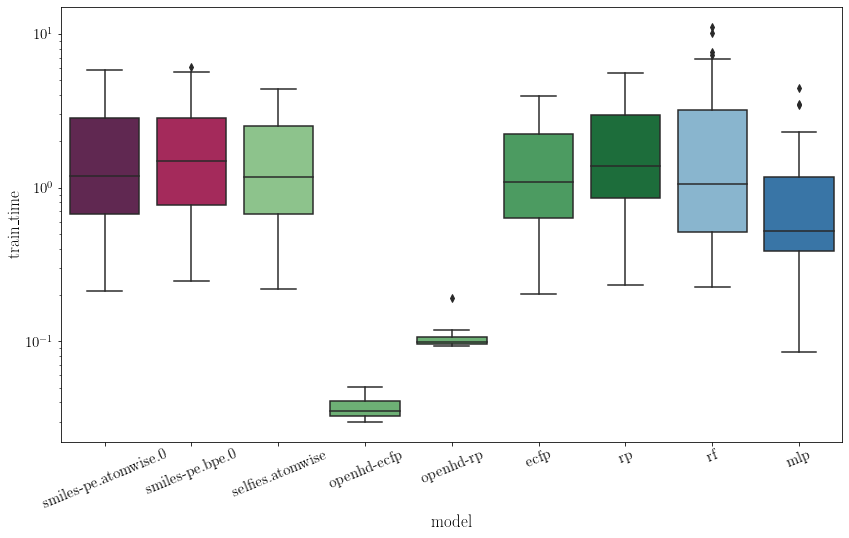

In [97]:
f, ax = plt.subplots(1,1, figsize=(14,8))

# for group_name, group_df in model_metric_df.groupby("model"):
#     sns.boxplot(data=group_df, x="train_time", ax=ax)
g = sns.boxplot(data=model_metric_df[model_metric_df["model"] != "Vina"], x="model", y="train_time", ax=ax, palette=color_dict)
ax.tick_params(axis="x", labelrotation=22.5)
g.set_yscale("log")

In [98]:
group_dict = {group_name: group_df for group_name, group_df in model_metric_df.groupby('model')}

In [99]:
group_dict["rp"]["train_time"].mean() / group_dict["openhd-rp"]["train_time"].mean()

19.864687543423006

In [100]:
group_dict["ecfp"]["train_time"].mean() / group_dict["openhd-ecfp"]["train_time"].mean()

41.74038920418333

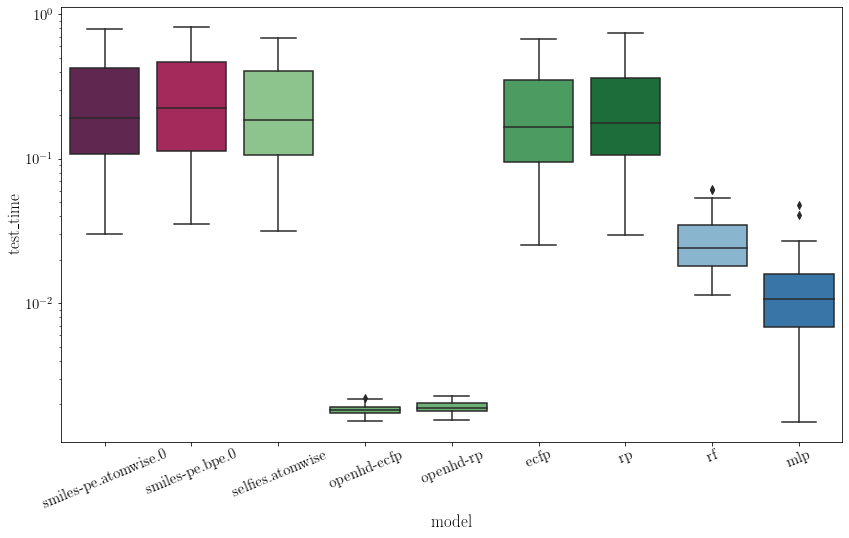

In [101]:
f, ax = plt.subplots(1,1, figsize=(14,8))

g = sns.boxplot(data=model_metric_df[model_metric_df["model"] != "Vina"], x="model", y="test_time", ax=ax, palette=color_dict)
ax.tick_params(axis="x", labelrotation=22.5)
g.set_yscale("log")

In [102]:
# sns.lineplot(data=model_metric_df, x="model", y="test_time")

In [103]:
group_dict["rf"]["test_time"].mean() / group_dict["rf"]["test_size"].mean()

2.2593216043764142e-05

In [104]:
group_dict["mlp"]["test_time"].mean() / group_dict["rf"]["test_size"].mean()

1.0749024067174423e-05

In [105]:
group_dict["ecfp"]["test_time"].mean() / group_dict["rf"]["test_size"].mean()

0.00018931656838014365

In [106]:
group_dict["openhd-ecfp"]["test_time"].mean() / group_dict["rf"]["test_size"].mean()

1.4876711211172797e-06

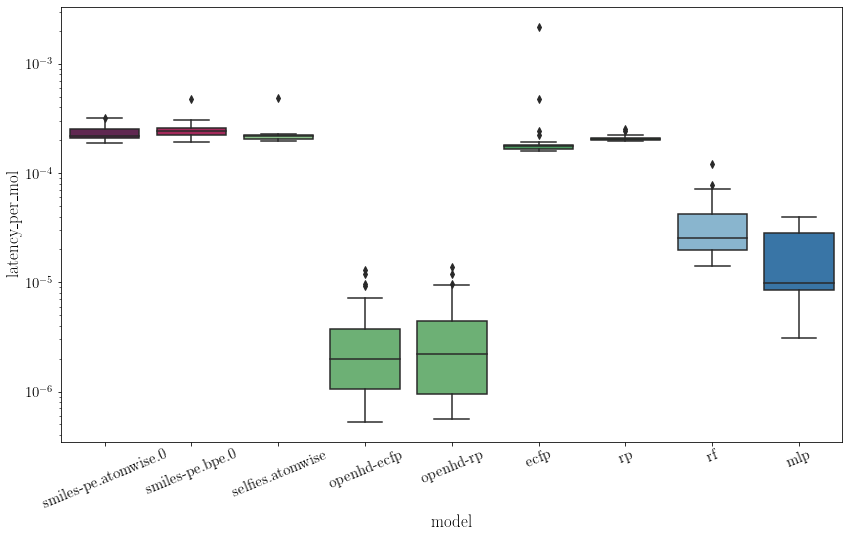

In [108]:
f, ax = plt.subplots(1,1, figsize=(14,8))

g = sns.boxplot(data=model_metric_df[model_metric_df["model"] != "Vina"], x="model", y="latency_per_mol", ax=ax, palette=color_dict)
ax.tick_params(axis="x", labelrotation=22.5)
g.set_yscale("log")

In [82]:
group_dict["ecfp"]["test_time"].mean() / group_dict["openhd-ecfp"]["test_time"].mean()

127.25700303838794

In [83]:
group_dict["rp"]["test_time"].mean() / group_dict["openhd-rp"]["test_time"].mean()

134.77375004944426

In [84]:
group_dict["rp"]["test_time"].mean()

0.2565294949631942

In [85]:
for group_name in group_dict.keys():
    print(f"{group_name}-{group_dict[group_name]['train_time'].mean()}")

Vina-nan
ecfp-1.5604145370659073
mlp-0.9281210509726877
openhd-ecfp-0.037383804195805594
openhd-rp-0.10364420664937872
rf-2.451891372078343
rp-2.0588597807758733
selfies.atomwise-1.710242604895642
smiles-pe.atomwise.0-1.8002140311190955
smiles-pe.bpe.0-2.0068377205572627


In [86]:
for group_name in group_dict.keys():
    print(f"{group_name}-{group_dict[group_name]['test_time'].mean()}")

Vina-nan
ecfp-0.23282450500287508
mlp-0.013219319519243744
openhd-ecfp-0.0018295614342940482
openhd-rp-0.00190340845208419
rf-0.027785493825611306
rp-0.2565294949631942
selfies.atomwise-0.2625335141232139
smiles-pe.atomwise.0-0.2723608556546663
smiles-pe.bpe.0-0.30056622028350827
